## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of this project is to understand the results of an A/B test run by an e-commerce website and to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

This project is part of the Udacity Data Analyst Nanodegree


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the seed
random.seed(42)

`1.` Now, we read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Now we find the number of rows in the dataset.

In [4]:
df.user_id.count()

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df[df['converted'] == 1].user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df_treatment = df[df['group'] == 'treatment']
a = df_treatment[df_treatment['landing_page'] == 'old_page'].user_id.count()

df_new = df[df['landing_page'] == 'new_page']
b = df_new[df_new['group'] == 'control'].user_id.count()

print(a+b)

3893


f. Check if any of the rows have missing values

In [8]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now we create a new dataset that meets the specifications from the quiz and store the new dataframe in **df2**.

In [9]:
df2 = df_treatment[df_treatment['landing_page'] == 'new_page']

df_control = df[df['group'] == 'control']
df_old = df_control[df_control['landing_page'] == 'old_page']

In [10]:
df2 = df2.append(df_old)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


`3.` Now we use **df2** and the cells below to answer questions below.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [16]:
df2.drop_duplicates()
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


`4.` Use **df2** in the cells below to answer the questions below.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2[df2['converted'] == 1].user_id.count()/df2.user_id.count()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control" and converted == 1').user_id.count() / df2[df2['group'] == 'control'].user_id.count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment" and converted == 1').user_id.count() / df2[df2['group'] == 'treatment'].user_id.count()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page'] == 'new_page'].user_id.count() / df2.user_id.count()

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>There is not sufficient evidence to conclude that the new treatment page leads to more conversions, given that there is a higher probability of converting among the control group than the treatment.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

><p> $H_{0}$ = $p_{new}$ - $p_{old}$ $\leq$ 0 </p>
><p> $H_{1}$ = $p_{new}$ - $p_{old}$ $>$ 0 </p>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2[df2['converted'] == 1].user_id.count()/df2.user_id.count()
print(p_new)

0.119596675671


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2[df2['converted'] == 1].user_id.count()/df2.user_id.count()
print(p_old)

0.119596675671


c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2[df2['group'] == 'treatment'].user_id.count()
print(n_new)

145311


d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2['group'] == 'control'].user_id.count()
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(2, p = p_new, size = n_new)
print(new_page_converted)

[0 0 0 ..., 0 1 0]


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(2, p = p_old, size = n_old)
print(old_page_converted)

[0 0 1 ..., 0 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
control_ctr = df2.query('group=="control"').converted.mean()
treatment_ctr = df.query('group=="treatment"').converted.mean()
obs_diff = treatment_ctr - control_ctr

print(obs_diff)

-0.00146672493556


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.

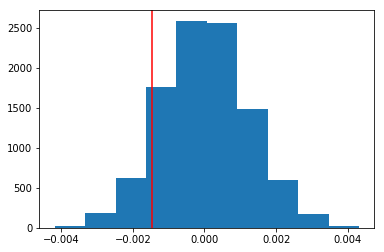

In [29]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs > obs_diff).mean()

0.89349999999999996

k. What was just computed in part **j.**?  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>What was just calculated was the p-value. If this was less than the standard of error $\alpha$ = 0.05, then we can conclude that it is statistically significant that people prefer the new page better than the old one.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.shape[0] - df2.query("landing_page == 'new_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_val = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_val)

-1.31160753391 0.905173705141


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>There is a low z-score and a p-value equal to 0.9, which shows that the difference in the conversion rates is not statistically significant enough to reject the null with a standard error of 0.05. The results agree with the prior findings, where we got a similiar p-value of 0.89

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression, since it is used to predict a categorical dependent variable using a given set of independent variables

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

df2['ab_page'] = (df2.group == 'treatment').astype(int)

df2['intercept'] = 1

c. Use **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [34]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-09 18:05 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>The p-value of 0.19 in this model differs from the value found in Part II because this is a two-sided test vs. a one-sided test in part II. Here we are just looking at differences from the null (whether less or greater), and not one of those individually.

f. Now, let's consider other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?

>It might be a good idea to consider other factors to add into the regression model because there may be significant factors that may be missed that inflates the significance of other factors. However, a caveat is that adding additional terms to the regression model may lead to multicollinearity amongst variables.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  We create dummy variables for these country columns and provide the statistical output as well as a written response to answer this question.

In [36]:
df_new = pd.read_csv('countries.csv')
df_new.country.value_counts()
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df3 = df2.join(df_new.set_index('user_id'), on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept,country,CA,UK,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,1,CA,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,1,CA,1,0,0


In [37]:
df3.groupby('country')['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119546
Name: converted, dtype: float64

In [38]:
df3['intercept'] = 1
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-09 18:05 AIC:              212781.0880
No. Observations:   290585           BIC:              212812.8269
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3154  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5176  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7462  0.4555  -0.0161   0.0360
==================================================================

"""

>When separated by country, it seems that the proportion of individuals that converted to the new page is about the same. So by itself, country of origin doesn't seem to have much of an effect on whether or not an individual converts.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  So we are creating the necessary additional columns, and fitting the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']

In [40]:
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK_ab_page', 'CA_ab_page']])
results3 = logit_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-09 18:20 AIC:              212779.1904
No. Observations:   290585           BIC:              212821.5090
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0183    0.0126    -1.4495  0.1472  -0.0430   0.0064
UK_ab_page    0.0257    0.0188     1.3640  0.1726  -0.0112   0.0625
CA_ab_page   -0.0644    0.0384    -1.6785  0.0933  -0.1396   0.0108
==================================================================

"""

>When looking at the interaction between page and country, the p-values are greater than our 0.05 margin of error.  When considered in tandem with the landing page that an individual initially received, it seems that country still does not have a statisically significant impact on whether or not a user converts to the new page.

### Conclusion

> Throughout this project, it has been observed that the treatment group is not more likely to convert to the new page than the control group. The probabilities in Part I showed that it was actually the control group that had the greater number of people converting to the new page. We look at Part II and Part III and we get p-values greater than our standard error that lead us to fail to reject the null hypothesis that states that the probability of converting to the new page is greater than the probability of not converting. Some of this may be due to change aversion, however, so it may be beneficial to extend the test period. At this time it does not seem beneficial to implement the new page, but perhaps the results may change with more data.

> The one-sided p-value test (in Part II) provided more power in determining whether the treatment is likely to lead to a greater conversion rate, but it doesn't provide any insight into whether the treatment actually has a negative effect on conversion rate, which can be determined by a two-sided p-value test (such as in Part III). Due to the size of the p-values in each test, we fail to reject the null hypothesis that the probability of converting to the new page is the same or less than the probability of staying with the old page.